#NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2024/25 (6 CFU) - Prof. Michele Rossi, Prof. Jacopo Pegoraro, Dr. Pietro Talli, Dr. Gianmaria Ventura
---

## Lab. 07 - Continual Learning


In this brief tutorial we will learn the basics of *Continual Learning* using *PyTorch*. We will use the standard MNIST benchmark.

Although current machine learning algorithms have acquired a good reputation in terms of achieving the goals they are trained to do, they are prone to foregtting old data. If one takes a trained model and fine-tunes it on different data, its performance on the old data deteriorates. This is what the community calls **Catastrophic Forgetting**. There are many questions that rotate around this concept, but in this notebook we are going to introduce the most basic ones.

This notebook has taken inspiration from the **[Continual AI Colab](https://github.com/ContinualAI/colab)**, which is a repository meant for tutorials and demo running on Google Colaboratory. [Continual AI](https://www.continualai.org/) is an open research community on the topic of Continual Learning and AI!

The notebook is divided into two parts:

1.   Introduction to Continual Learning: we will start with learning over the standard *MNIST* benchmark, then we will move in the actual continual learning setting  with the *Permuted MNIST* benchmark.

2.   Rehearsal (aka Replay) strategies: we will analyze how the performance is affected when we train our models in a temporal fashion and we will investigate which are the basic remedies to avoid deterioration over time.


In [1]:
import torch
torch.cuda.is_available()

True

That's great, let us import then a few libraries, which we'll be using during this tutorial!

In [2]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

## MNIST: Digits recognition with PyTorch

All right, let's start then making sure we all know the basics! Let's recognize the ten handwritten digits learning from 60.000, 28x28 grayscale images.
For simplicity let's import a loading script we have already developed inside the **Continual AI Colab** repository:

In [3]:
!git clone https://github.com/ContinualAI/colab.git continualai/colab

fatal: destination path 'continualai/colab' already exists and is not an empty directory.


In [4]:
from continualai.colab.scripts import mnist
mnist.init()

Files already downloaded!


In [5]:
x_train, t_train, x_test, t_test = mnist.load()

print("x_train dim and type: ", x_train.shape, x_train.dtype)
print("t_train dim and type: ", t_train.shape, t_train.dtype)
print("x_test dim and type: ", x_test.shape, x_test.dtype)
print("t_test dim and type: ", t_test.shape, t_test.dtype)

x_train dim and type:  (60000, 1, 28, 28) float32
t_train dim and type:  (60000,) uint8
x_test dim and type:  (10000, 1, 28, 28) float32
t_test dim and type:  (10000,) uint8


Let's take a look at the actual images!

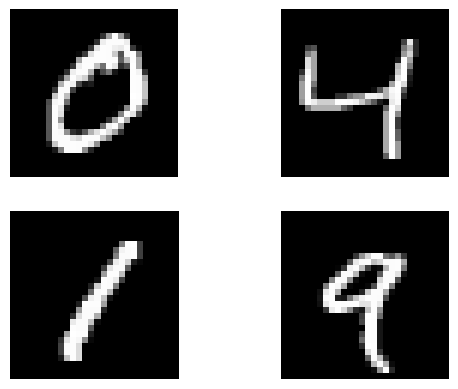

In [6]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(x_train[1, 0], cmap="gray")
axarr[0,1].imshow(x_train[2, 0], cmap="gray")
axarr[1,0].imshow(x_train[3, 0], cmap="gray")
axarr[1,1].imshow(x_train[4, 0], cmap="gray")
np.vectorize(lambda ax:ax.axis('off'))(axarr);

Good! Let's now set up a few general setting before using torch...

In [7]:
# switch to False to use CPU
use_cuda = True

use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu");
torch.manual_seed(1);

... and define our first conv-net! (You can choose the architecture)

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.dropout = nn.Dropout2d(0.25)
        self.act = nn.ReLU()
        self.fc = nn.Linear(9216, 10)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act(self.batch_norm1(self.conv1(x)))
        x = self.act(self.batch_norm2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

Then we can write the *train* and *test* functions. Note that for simplicity here we are not using PyTorch [Data Loaders](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) but this is not recommended for efficiency.

In [9]:
def train(model, device, x_train, t_train, optimizer, epoch):
    model.train()

    for start in range(0, len(t_train)-1, 256):
      end = start + 256
      x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
      x, y = x.to(device), y.to(device)

      optimizer.zero_grad()

      output = model(x)
      loss = F.cross_entropy(output, y)
      loss.backward()
      optimizer.step()
      #print(loss.item())
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

def test(model, device, x_test, t_test):
    model.eval()
    test_loss = 0
    correct = 0
    for start in range(0, len(t_test)-1, 256):
      end = start + 256
      with torch.no_grad():
        x, y = torch.from_numpy(x_test[start:end]), torch.from_numpy(t_test[start:end]).long()
        x, y = x.to(device), y.to(device)
        output = model(x)
        test_loss += F.cross_entropy(output, y).item() # sum up batch loss
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(t_test)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(t_test),
        100. * correct / len(t_test)))
    return 100. * correct / len(t_test)

Then we are ready to instantiate our model and start the training!

In [10]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [11]:
for epoch in range(1, 3):
  train(model, device, x_train, t_train, optimizer, epoch)
  acc_upper_limit = test(model, device, x_test, t_test)

Train Epoch: 1 	Loss: 0.236033
Test set: Average loss: 0.0003, Accuracy: 9763/10000 (98%)

Train Epoch: 2 	Loss: 0.207702
Test set: Average loss: 0.0002, Accuracy: 9824/10000 (98%)



**Questions to explore:**

*   Can you find a better parametrization to improve the final accuracy?
*   Can you change the network architecture to improve the final accuracy?
*   Can you achieve the same performance with a smaller architecture?
*   What's the difference in accuracy if you change convolutions with fully connected layers?

But what if now we want we the same model being able to solve a new task we encounter over time like a permuted version of the same MNIST? Let's define our custom function to permute it!

In [12]:
def permute_mnist(mnist, seed):
    """ Given the training set, permute pixels of each img the same way. """

    np.random.seed(seed)
    print("starting permutation...")
    h = w = 28
    perm_inds = list(range(h*w))
    np.random.shuffle(perm_inds)
    # print(perm_inds)
    perm_mnist = []
    for set in mnist:
        num_img = set.shape[0]
        flat_set = set.reshape(num_img, w * h)
        perm_mnist.append(flat_set[:, perm_inds].reshape(num_img, 1, w, h))
    print("done.")
    return perm_mnist

In [13]:
x_train2, x_test2 = permute_mnist([x_train, x_test], 0)

starting permutation...
done.


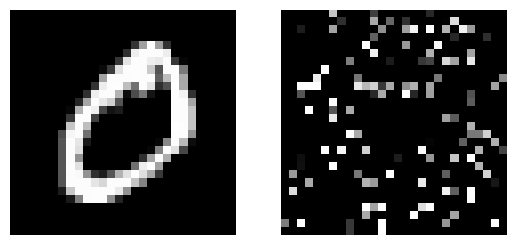

In [14]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[1, 0], cmap="gray")
axarr[1].imshow(x_train2[2, 0], cmap="gray")
np.vectorize(lambda ax:ax.axis('off'))(axarr);

Amazing. Now let's see how our pre-trained model is working on both the original and the permuted MNIST dataset:

In [15]:
print("Testing on the first task:")
test(model, device, x_test, t_test)

print("Testing on the second task:")
test(model, device, x_test2, t_test);

Testing on the first task:
Test set: Average loss: 0.0002, Accuracy: 9824/10000 (98%)

Testing on the second task:
Test set: Average loss: 0.0198, Accuracy: 1595/10000 (16%)



Mmmh... that's pretty bad, our model cannot generalize to this apparently very different new task! Well, we can just finetune our model using the new permuted training set!

In [16]:
for epoch in range(1, 3):
  train(model, device, x_train2, t_train, optimizer, epoch)
  test(model, device, x_test2, t_test)

Train Epoch: 1 	Loss: 0.266082
Test set: Average loss: 0.0010, Accuracy: 9193/10000 (92%)

Train Epoch: 2 	Loss: 0.222661
Test set: Average loss: 0.0007, Accuracy: 9416/10000 (94%)



In [17]:
print("Testing on the first task:")
test(model, device, x_test, t_test)

print("Testing on the second task:")
test(model, device, x_test2, t_test);

Testing on the first task:
Test set: Average loss: 0.0083, Accuracy: 3599/10000 (36%)

Testing on the second task:
Test set: Average loss: 0.0007, Accuracy: 9416/10000 (94%)



This is very annoying! Now we are not able to solve the original MNIST task anymore! :-( This is the phenomenon known in literature as **Catastrophic Forgetting**! In the following section we well compare three different strategies for learning continually (and trying to not forget!)

**Questions to explore:**

*   Can simple Dropout and Regularization techniques reduce forgetting?
*   In the permuted MNIST task, do convolutions still help increasing the accuracy?

Some tips here: https://papers.nips.cc/paper/5059-compete-to-compute

## CL Strategies

Let us now focus on some strategies for reducing catastrofic forgetting, one of the principal problems when learning continuously. in this section we will take a look at three different strategies:

1.   Naive
2.   Rehearsal
3.   Elastic Weight Consolidation (EWC)




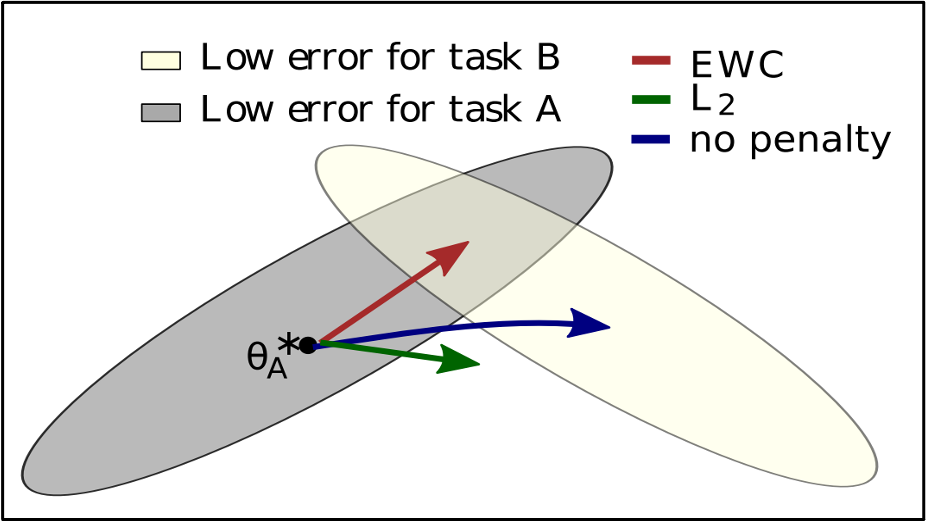

We will run such strategies on a 3-tasks Permuted MNIST. Finally we will plot our results for comparison.

Let's start by defining our 3 tasks with the function we have already introduced before:

In [18]:
# task 1
task_1 = [(x_train, t_train), (x_test, t_test)]

# task 2
x_train2, x_test2 = permute_mnist([x_train, x_test], 1)
task_2 = [(x_train2, t_train), (x_test2, t_test)]

# task 3
x_train3, x_test3 = permute_mnist([x_train, x_test], 2)
task_3 = [(x_train3, t_train), (x_test3, t_test)]

# task list
tasks = [task_1, task_2, task_3]

starting permutation...
done.
starting permutation...
done.


Let's start by defining a function to shuffle our data: we will need it for rehearsal.



In [19]:
def shuffle_in_unison(dataset, seed, in_place=False):
    """ Shuffle two (or more) list in unison. """

    np.random.seed(seed)
    rng_state = np.random.get_state()
    new_dataset = []
    for x in dataset:
        if in_place:
            np.random.shuffle(x)
        else:
            new_dataset.append(np.random.permutation(x))
        np.random.set_state(rng_state)

    if not in_place:
        return new_dataset

Now let's define the training function with option for rehearsal.
We reset the model and optimizer and run our training over the tasks sequence:

In [20]:
def train_reh(past_examples_percentage=1, epochs=2):
  model = Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  rehe_accs = []
  for id, task in enumerate(tasks):
    avg_acc = 0
    print("Training on task: ", id)

    (x_train, t_train), _ = task

    # for previous task
    for i in range(id):
      (past_x_train, past_t_train), _ = tasks[i]
      example_num = int(past_examples_percentage * len(past_t_train))
      x_train = np.concatenate((x_train, past_x_train[:example_num]))
      t_train = np.concatenate((t_train, past_t_train[:example_num]))

    x_train, t_train = shuffle_in_unison([x_train, t_train], 0)

    for epoch in range(epochs):
      train(model, device, x_train, t_train, optimizer, epoch)

    for id_test, task in enumerate(tasks):
      print("Testing on task: ", id_test)
      _, (x_test, t_test) = task
      acc = test(model, device, x_test, t_test)
      avg_acc = avg_acc + acc

    print("Avg acc: ", avg_acc / 3)
    rehe_accs.append(avg_acc/3)
  return rehe_accs

### Naive Strategy

The  *Naive* strategy, is the simple idea of continuing the back-prop process on the new batches/tasks. This is very simple, but at the same time very prone to forgetting as we have witnessed before. Let's see how it works on three tasks:

In [21]:
print('ACCURACY ON NAIVE FINE-TUNING STRATEGY')
accs_naive = train_reh(0) # naive: 0%

ACCURACY ON NAIVE FINE-TUNING STRATEGY
Training on task:  0
Train Epoch: 0 	Loss: 0.065399
Train Epoch: 1 	Loss: 0.043436
Testing on task:  0
Test set: Average loss: 0.0002, Accuracy: 9845/10000 (98%)

Testing on task:  1
Test set: Average loss: 0.0257, Accuracy: 1059/10000 (11%)

Testing on task:  2
Test set: Average loss: 0.0224, Accuracy: 1397/10000 (14%)

Avg acc:  41.00333333333334
Training on task:  1
Train Epoch: 0 	Loss: 0.361764
Train Epoch: 1 	Loss: 0.263073
Testing on task:  0
Test set: Average loss: 0.0173, Accuracy: 2230/10000 (22%)

Testing on task:  1
Test set: Average loss: 0.0009, Accuracy: 9363/10000 (94%)

Testing on task:  2
Test set: Average loss: 0.0152, Accuracy: 1305/10000 (13%)

Avg acc:  42.99333333333333
Training on task:  2
Train Epoch: 0 	Loss: 0.284707
Train Epoch: 1 	Loss: 0.232723
Testing on task:  0
Test set: Average loss: 0.0143, Accuracy: 2093/10000 (21%)

Testing on task:  1
Test set: Average loss: 0.0030, Accuracy: 7426/10000 (74%)

Testing on task:

**Questions to explore:**

*   Does the order of the tasks effect the final results?


### Rehearsal Strategy

Another simple CL idea is to carry on *all* or *part* of the previously encountered examples (of the previous tasks), shuffling them with the data of the current task. Using *all* the past data is near to the optimal performance we can desire at the end of the task sequence but at the expense of much bigger memory usage.

Why? Well, just because we have all the domain distribution available at once, so the model can easily converge to  a region where the loss is low.

We compute the accuracy on a complete rehearsal and on a rehearsal which uses only 5% of the data for each task!

In [22]:
print('ACCURACY ON REHEARSAL STRATEGY STORING ALL PREVIOUS EXAMPLES')
accs_rehearsal_all = train_reh(1) # regural supervised fashion: 100%
print('ACCURACY ON REHEARSAL STRATEGY STORING 5% EXAMPLES')
accs_rehearsal_5 = train_reh(0.05) # 5% of previous samples for each task

ACCURACY ON REHEARSAL STRATEGY STORING ALL PREVIOUS EXAMPLES
Training on task:  0
Train Epoch: 0 	Loss: 0.084688
Train Epoch: 1 	Loss: 0.041220
Testing on task:  0
Test set: Average loss: 0.0002, Accuracy: 9820/10000 (98%)

Testing on task:  1
Test set: Average loss: 0.0289, Accuracy: 988/10000 (10%)

Testing on task:  2
Test set: Average loss: 0.0241, Accuracy: 1236/10000 (12%)

Avg acc:  40.14666666666667
Training on task:  1
Train Epoch: 0 	Loss: 0.102657
Train Epoch: 1 	Loss: 0.091700
Testing on task:  0
Test set: Average loss: 0.0002, Accuracy: 9818/10000 (98%)

Testing on task:  1
Test set: Average loss: 0.0006, Accuracy: 9557/10000 (96%)

Testing on task:  2
Test set: Average loss: 0.0125, Accuracy: 1645/10000 (16%)

Avg acc:  70.06666666666666
Training on task:  2
Train Epoch: 0 	Loss: 0.087953
Train Epoch: 1 	Loss: 0.012169
Testing on task:  0
Test set: Average loss: 0.0002, Accuracy: 9843/10000 (98%)

Testing on task:  1
Test set: Average loss: 0.0005, Accuracy: 9625/10000 (9

**Questions to explore:**

*   Can you find a way to reduce the number of examples of the previous tasks to maintain in memory?
*   Can you find a good trade-off between memory overhead and final accuracy?
*   Why is shuffling needed here?

### Elastic Weights Consolidation (EWC) Strategy

Elastic Weights Consolidation (EWC) is a common CL strategy firstly proposed in the paper: "[Overcoming catastrophic forgetting in neural networks](https://arxiv.org/abs/1612.00796)" for deep neural networks.

It is based on the computation of the importance of each weight (fisher information) and a squared regularization loss, penalizing changes in the most important wheights for the previous tasks.

It has the great advantage of **not using any** of the previous tasks data!

In [23]:
fisher_dict = {}
optpar_dict = {}
ewc_lambda = 0.5

In [24]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

Now we need to define an additional function to compute the fisher information for each weight at the end of each task:

In [25]:
def on_task_update(task_id, x_mem, t_mem):

  model.train()
  optimizer.zero_grad()

  # accumulating gradients
  for start in range(0, len(t_mem)-1, 256):
      end = start + 256
      x, y = torch.from_numpy(x_mem[start:end]), torch.from_numpy(t_mem[start:end]).long()
      x, y = x.to(device), y.to(device)
      output = model(x)
      loss = F.cross_entropy(output, y)
      loss.backward()

  fisher_dict[task_id] = {}
  optpar_dict[task_id] = {}

  # gradients accumulated can be used to calculate fisher
  for name, param in model.named_parameters():

    optpar_dict[task_id][name] = param.data.clone()
    fisher_dict[task_id][name] = param.grad.data.clone().pow(2)

We need also to modify our *train* function to add the new regularization loss:
Given the fisher coefficients $F_t$ and the network parameters $W_t$ for task $t$, the regularization loss can be computed as follows:
$$\mathcal{L}_{reg}(t) = \lambda_{ewc}sum(F_t(W_t - W_{current})^2)$$
Where the sum function sums over all the parameters, $W_{current}$ are the current weights of the network and $\lambda_{ewc}$ is a constant used to weight the regularization loss

In [26]:
def train_ewc(model, device, task_id, x_train, t_train, optimizer, epoch):
    model.train()

    for start in range(0, len(t_train)-1, 256):
      end = start + 256
      x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
      x, y = x.to(device), y.to(device)

      optimizer.zero_grad()

      output = model(x)
      loss = F.cross_entropy(output, y)

      ### magic here! :-) Implement the EWC regularization factor.
      for task in range(task_id):
        for name, param in model.named_parameters():
          fisher = fisher_dict[task][name]
          optpar = optpar_dict[task][name]
          loss += ewc_lambda * torch.sum(fisher * (optpar - param).pow(2))

      loss.backward()
      optimizer.step()
      #print(loss.item())
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

Finally we can run the train over the three tasks sequence of th *Permuted MNIST*:

In [27]:
ewc_accs = []
for id, task in enumerate(tasks):
  avg_acc = 0
  print("Training on task: ", id)

  (x_train, t_train), _ = task

  for epoch in range(1, 3):
    train_ewc(model, device, id, x_train, t_train, optimizer, epoch)
  on_task_update(id, x_train, t_train)

  for id_test, task in enumerate(tasks):
    print("Testing on task: ", id_test)
    _, (x_test, t_test) = task
    acc = test(model, device, x_test, t_test)
    avg_acc = avg_acc + acc

  print("Avg acc: ", avg_acc / 3)
  ewc_accs.append(avg_acc / 3)

Training on task:  0
Train Epoch: 1 	Loss: 0.223550
Train Epoch: 2 	Loss: 0.204281
Testing on task:  0
Test set: Average loss: 0.0002, Accuracy: 9813/10000 (98%)

Testing on task:  1
Test set: Average loss: 0.0271, Accuracy: 982/10000 (10%)

Testing on task:  2
Test set: Average loss: 0.0230, Accuracy: 1303/10000 (13%)

Avg acc:  40.32666666666666
Training on task:  1
Train Epoch: 1 	Loss: 0.488343
Train Epoch: 2 	Loss: 0.398279
Testing on task:  0
Test set: Average loss: 0.0040, Accuracy: 6855/10000 (69%)

Testing on task:  1
Test set: Average loss: 0.0008, Accuracy: 9345/10000 (93%)

Testing on task:  2
Test set: Average loss: 0.0123, Accuracy: 1938/10000 (19%)

Avg acc:  60.46
Training on task:  2
Train Epoch: 1 	Loss: 0.740395
Train Epoch: 2 	Loss: 0.622120
Testing on task:  0
Test set: Average loss: 0.0022, Accuracy: 8159/10000 (82%)

Testing on task:  1
Test set: Average loss: 0.0020, Accuracy: 8330/10000 (83%)

Testing on task:  2
Test set: Average loss: 0.0019, Accuracy: 8422/1

**Questions to explore:**

*   How much the `ewc_lambda` parameter effect the final results?
*   Can you find a better parametrization to improve stability?
*   Can you find the memory overhead introduced by EWC with respect to the Naive approach?

Some tips here: https://arxiv.org/pdf/1805.06370.pdf

### Plot Results

To conclude, let's summerize our results in a nice plot! :-)

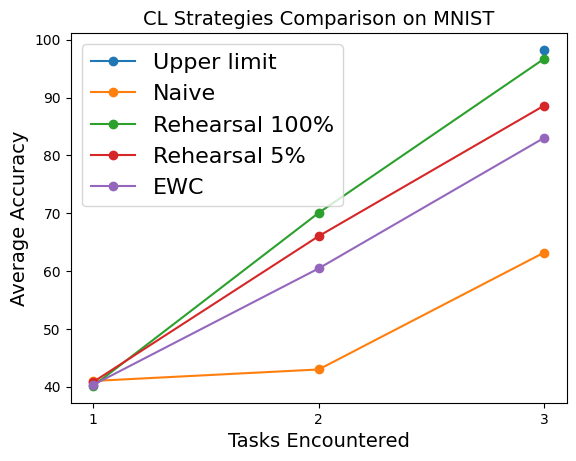

In [28]:
plt.plot([3], [acc_upper_limit], '-o', label="Upper limit")
plt.plot([1, 2, 3], accs_naive, '-o', label="Naive")
plt.plot([1, 2, 3], accs_rehearsal_all, '-o', label="Rehearsal 100%")
plt.plot([1, 2, 3], accs_rehearsal_5, '-o', label="Rehearsal 5%")
plt.plot([1, 2, 3], ewc_accs, '-o', label="EWC")
plt.xlabel('Tasks Encountered', fontsize=14)
plt.ylabel('Average Accuracy', fontsize=14)
plt.title('CL Strategies Comparison on MNIST', fontsize=14);
plt.xticks([1, 2, 3])
plt.legend(prop={'size': 16});

**Questions to explore:**

*   What's the difference in terms of memory utilization among the three methods?
*   Can you plot a similar graph highlighting the memory increase over time?

Some tips here: https://stackoverflow.com/questions/449560/how-do-i-determine-the-size-of-an-object-in-python/30316760

Copyright (c) 2018. Continual AI. All rights reserved.

See the accompanying LICENSE file in the GitHub repository for terms.                                                                                             
Website: continualai.org                                             